## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [3]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=10000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=5000, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=400,     # Number of episodes sampled from experience buffer
    updateInterval=40, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='3Gens-Cost-5k-cuda-huge_batch'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.05)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=510.0, beta=7.7, gamma=0.00142), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=78.0, beta=7.55, gamma=0.00482), minPower=0.5, maxPower=5.0, noiseLevel=0.05)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=10000, maxSteps=100, bufferSize=5000, traceLength=15, batchSize=400, updateInterval=40, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='3Gens-Cost-5k-cuda-huge_batch')

Train Agents

In [4]:
def rewardFn(totalCost, outputDifferential):
    scaledCost = totalCost/(100000.0) # Scale down cost to levels near the ones found in output differential (e.g. 0.1 */ 0.01)
    costComponent = 2**(-1*(scaledCost**2)*200)
    outputComponent = 2**(-1*(outputDifferential**2)*500)
    earnedReward = costComponent*outputComponent
    
#     print(f'Scaled_Cost:{scaledCost} - OutputDiff:{outputDifferential} - costComponent:{costComponent} - outputComponent:{outputComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total':earnedReward}

In [5]:
from learning.cost import ModelAdapterCost as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0917 23:38:11.096312 18504 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0917 23:38:11.104292 18504 deprecation.py:323] From C:\Users\flavi\Documents\Study\City-UniLondon\Thesis\2019-MSc_Thesis\app\learning\actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0917 23:38:11.194051 18504 deprecation.py:323] From C:\Users\flavi\Documents\Study\City-UniLondon\Thesis\2019-MSc_Thesis\app\learning\actor.py:38: dynamic_rnn (from tensorflow.python.ops.rn

Training model: 3Gens-Cost-5k-cuda-huge_batch - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: C:\Users\flavi\Documents\Study\City-UniLondon\Thesis\2019-MSc_Thesis\app\models\3Gens-Cost-5k-cuda-huge_batch\model
Wall time: 5h 39min 11s


In [6]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

W0918 08:04:51.867111 139924339623680 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0918 08:04:51.868197 139924339623680 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0918 08:04:51.884288 139924339623680 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Alternatively, one can plot the data to better inspect the progression

In [7]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

In [ ]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

In [ ]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

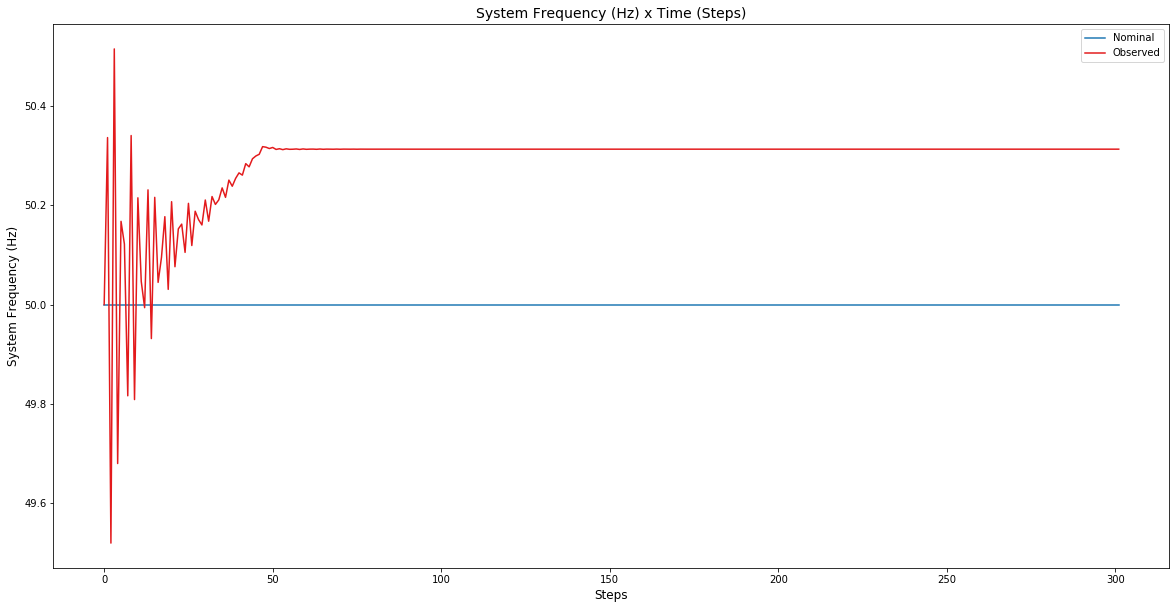

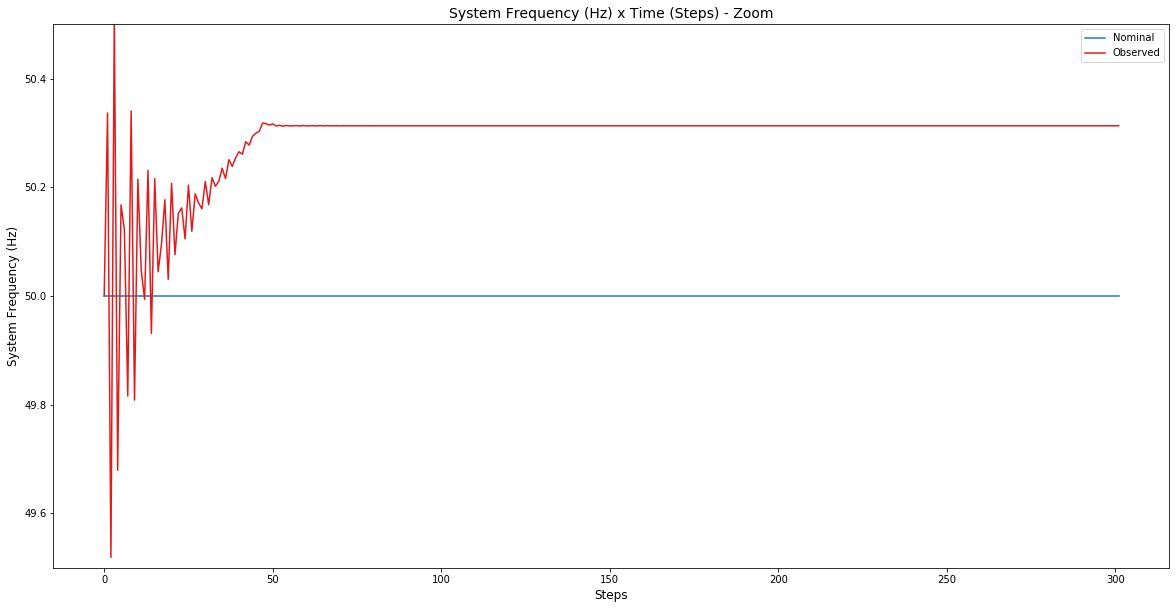

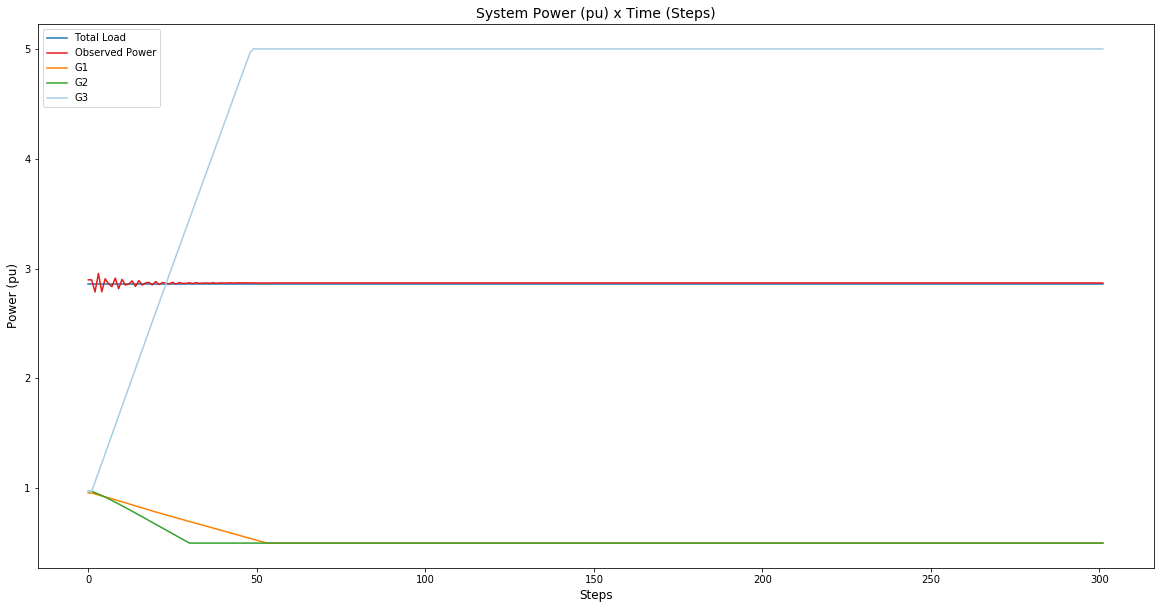

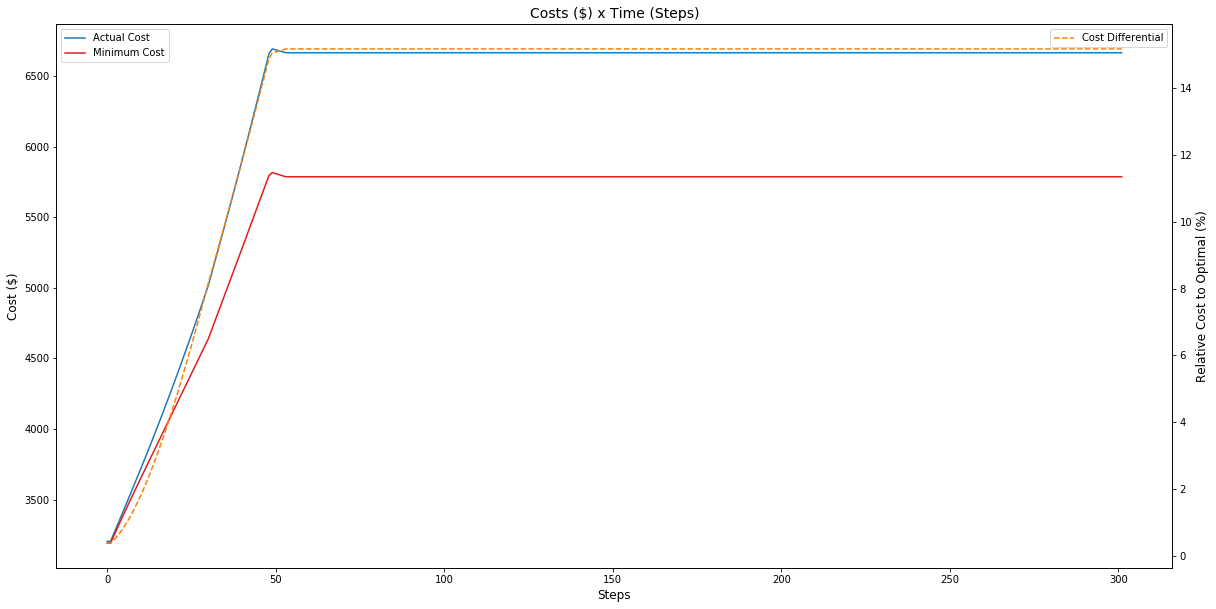

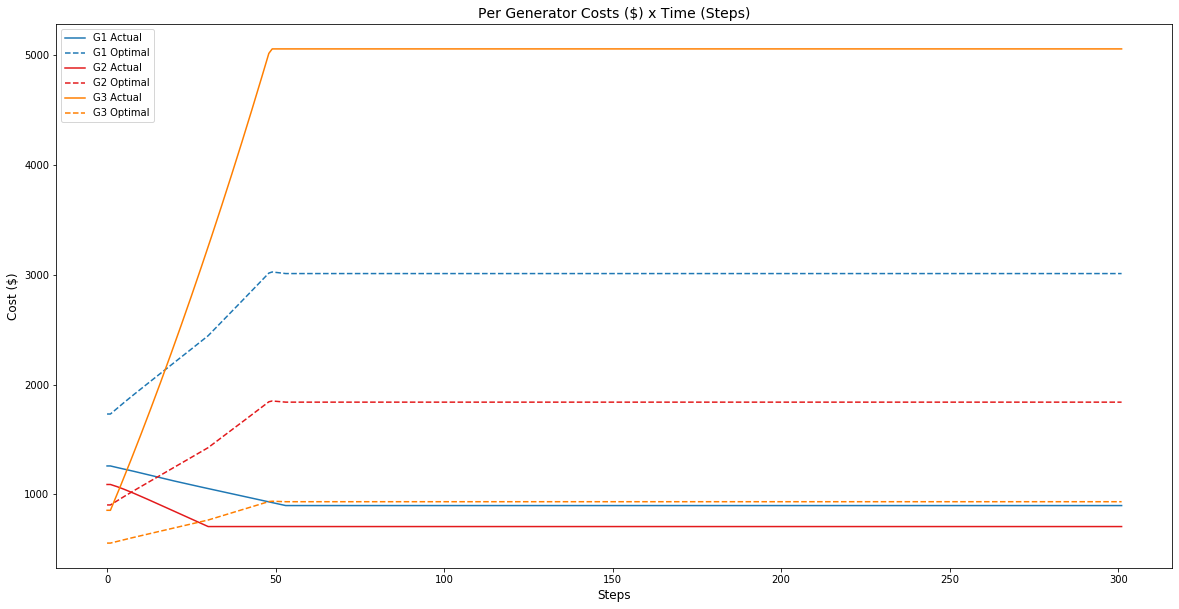

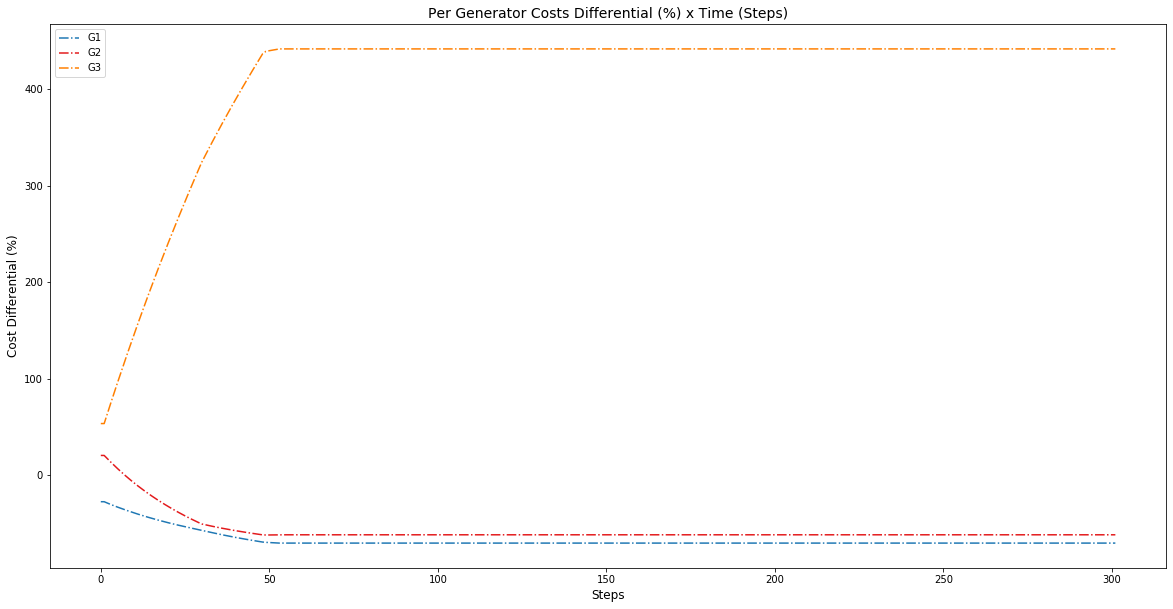

In [8]:
plotAll(electricalSystem.systemHistory)

In [ ]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [ ]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [ ]:
LearningState().model.allRewards

In [ ]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()